In [1]:
import matplotlib as  mpl
mpl.rcParams[u'font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [3]:
def show_two_img(img, dst, title_img='原始图像', title_dst='处理后图像'):
    plt.figure(figsize=(16, 9))
    plt.subplot(121)
    plt.axis('off')
    plt.title(title_img, fontsize=20)
    plt.imshow(img)
    plt.subplot(122)
    plt.axis('off')
    plt.title(title_dst, fontsize=20)
    plt.imshow(dst)
    plt.show()

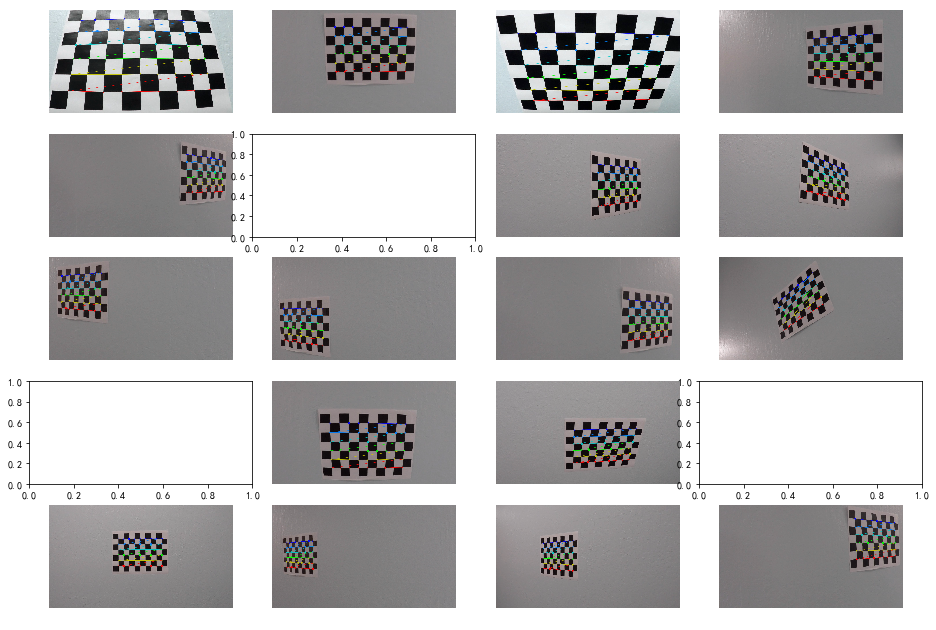

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# 设置寻找亚像素角点的参数，采用的停止准则是最大循环次数30和最大误差容限0.001
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    # 读入图像
    img = cv2.imread(fname)
    # 转化成灰度图 
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # 找到棋盘角点（9,6）
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)

        # 亚像素精确定位角点位置
        corners2 = cv2.cornerSubPix(gray,corners,(11, 11),(-1,-1),criteria)
        if corners2 is not None:
            imgpoints.append(corners2)
        else:
            imgpoints.append(corners)
        # 图上绘制检测到的角点
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)
        # 角点不全的图片不予显示

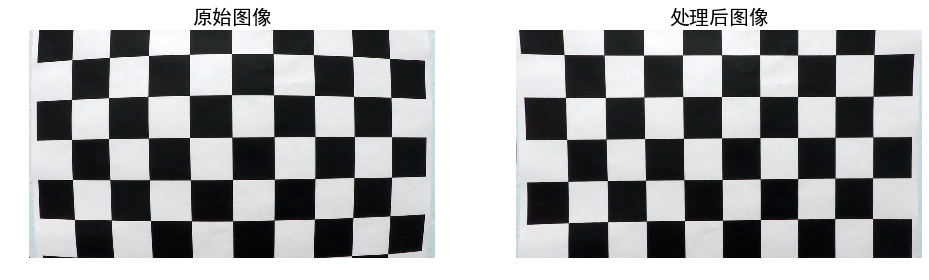

In [5]:
# 标定
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

h,  w = img.shape[:2]
# 优化相机矩阵
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),0,(w,h))
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

show_two_img(img, dst)

# 保存相机矩阵
dist_pickle = {}
dist_pickle["newcameramtx"] = newcameramtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

In [6]:
def undistort(img):
    """
    消除畸变函数
    """
    global newcameramtx
    undist = cv2.undistort(img, newcameramtx, dist, None, newcameramtx)
    return undist

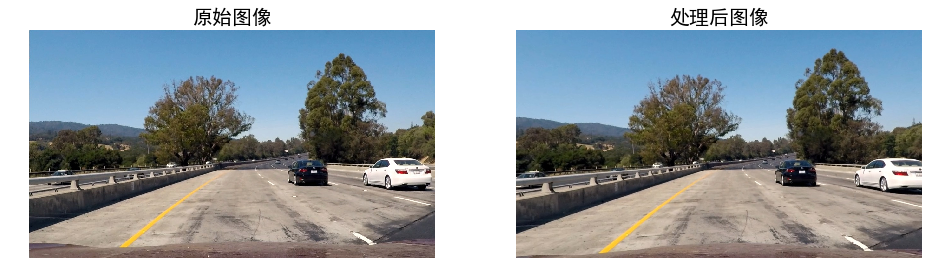

In [7]:
# 测试实例
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_undistort = undistort(img)

# 显示
show_two_img(img, img_undistort)

In [8]:
def warp(img, src, dst):
    h,w = img.shape[:2]
    # 通过 cv2.getPerspectiveTransform() 获取转换矩阵M以及M的逆矩阵
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # 通过 cv2.warpPerspective() 获取图像的鸟瞰图
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    # 返回转换后的图像和转换矩阵以及逆矩阵
    return warped, M, Minv

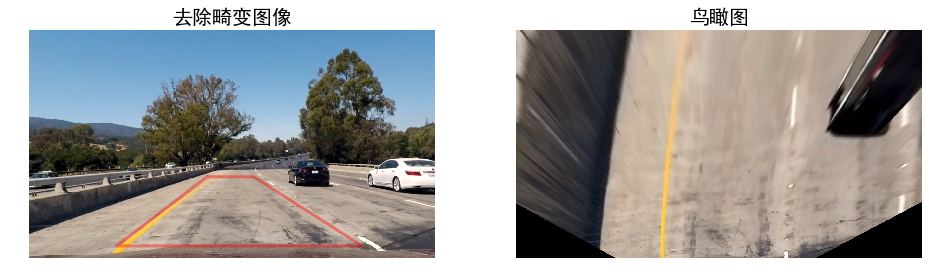

In [9]:
h,w = img_undistort.shape[:2]

# 定义源坐标点与目标点
src = np.float32([(560,464),
                  (707,464), 
                  (275,682), 
                  (1049,682)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

img_warped, M, Minv = warp(img_undistort, src, dst)


x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]


plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
plt.axis('off')
plt.title('去除畸变图像', fontsize=20)
plt.imshow(img_undistort)

plt.subplot(122)
plt.axis('off')
plt.title('鸟瞰图', fontsize=20)
plt.imshow(img_warped)
plt.show()


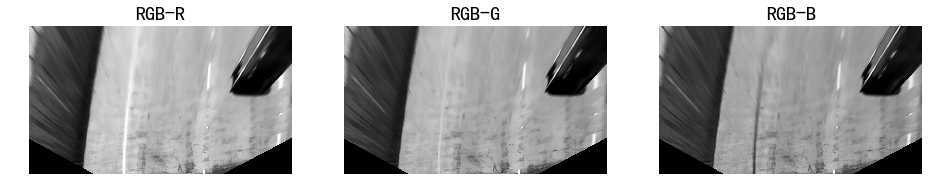

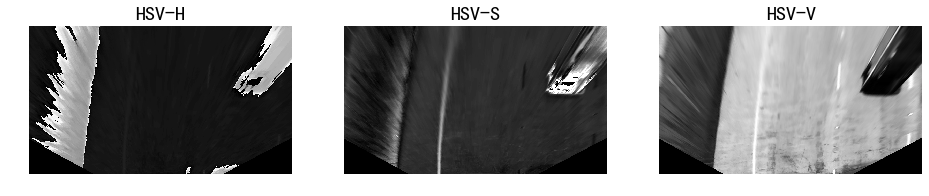

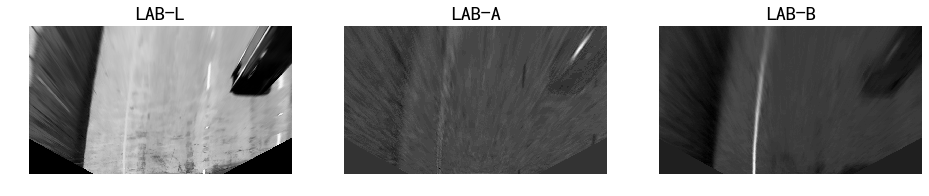

In [10]:
# 测试不同色域和通道
def show_channels(img, channel):
    """
    显示图像不同通道
    """
    plt.figure(figsize=(16, 9))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.axis('off')
        plt.title(channel+'-'+channel[i], fontsize=20)
        plt.imshow(img[:, :, i], cmap='gray')
    plt.show()

# RGB
show_channels(img_warped, 'RGB')
# HSV
img_warped_HSV = cv2.cvtColor(img_warped, cv2.COLOR_RGB2HSV)
show_channels(img_warped_HSV, 'HSV')
# LAB
img_warped_LAB = cv2.cvtColor(img_warped, cv2.COLOR_RGB2LAB)
show_channels(img_warped_LAB, 'LAB')

In [11]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale === or LAB L channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    abs_scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    mask = np.zeros_like(abs_scaled)
    mask[(abs_scaled >= thresh_min) & (abs_scaled <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return mask

In [12]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_sobel_thresh(img, sobel_kernel=25, mag_thresh=(25, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    g_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    g_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag = np.sqrt(np.square(g_x) + np.square(g_y))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    mag_scaled = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    mask = np.zeros_like(mag_scaled)
    mask[(mag_scaled >= mag_thresh[0]) & (mag_scaled <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask

In [13]:
def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    mask = np.zeros_like(lab_b)
    mask[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return mask

def hsv_vthresh(img, thresh=(225, 255)):
    # 1) Convert to HLS color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_v = hsv[:,:,2]
    hsv_v = hsv_v*(255/np.max(hsv_v))
    # 2) Apply a threshold to the L channel
    mask = np.zeros_like(hsv_v)
    mask[(hsv_v > thresh[0]) & (hsv_v <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return mask

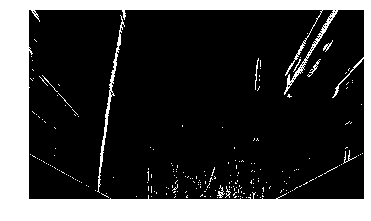

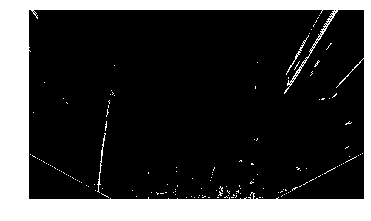

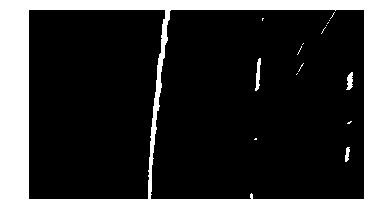

In [14]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_undistort = undistort(img)
img_warped, M, Minv = warp(img_undistort, src, dst)

img_sobelAbs = abs_sobel_thresh(img_warped)
img_sobelmag = mag_sobel_thresh(img_warped)
img_hsv = hsv_vthresh(img_warped)
plt.axis('off')
plt.imshow(img_sobelAbs, cmap='gray')
plt.show()
plt.axis('off')
plt.imshow(img_sobelmag, cmap='gray')
plt.show()
plt.axis('off')
plt.imshow(img_hsv, cmap='gray')
plt.show()

In [38]:
# Define the complete image processing pipeline, reads raw image and returns binary image with lane lines identified
# (hopefully)
def pipeline(img):
    
    h, w = img.shape[:2]
    # Undistort
    img_undistort = undistort(img)
    
    # Perspective Transform
    src = np.float32([(560,464),
                  (707,464), 
                  (275,682), 
                  (1049,682)])

    dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])
    img_warped, M, Minv = warp(img_undistort, src, dst)

    
    img_VThresh = hsv_vthresh(img_warped)

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(img_warped)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_BThresh == 1) | (img_VThresh == 1)] = 1
    return combined, Minv

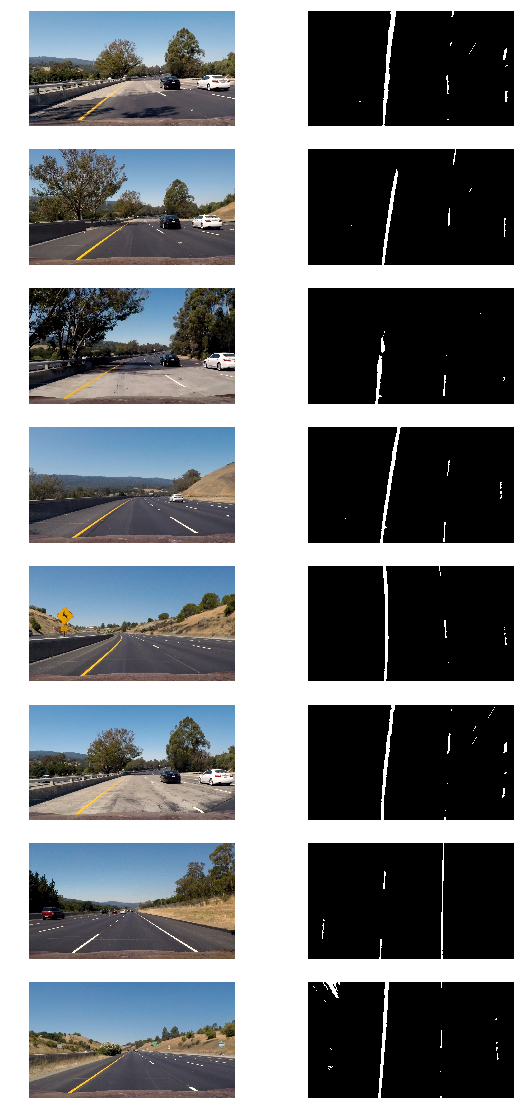

In [16]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

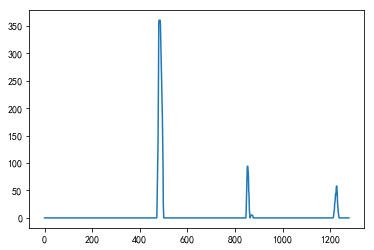

In [62]:
histogram = np.sum(img_bin[img_bin.shape[0]//2:,:], axis=0)
plt.plot(list(range(1280)), histogram)
plt.show()

In [17]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    """
    滑窗&拟合
    """
    # 截取图片下半部分制作直方图(从测试数据看上半部分绝大多数是天空和背景)
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    # 定位直方图左侧与右侧的峰值位置
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # 获取峰值的x索引
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    # 设置滑窗个数
    nwindows = 10
    # 计算滑窗高度
    window_height = np.int(img.shape[0]/nwindows)
    # 获得所有非零项索引
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # 更新当前滑窗的坐标
    leftx_current = leftx_base
    rightx_current = rightx_base
    # 设置滑窗宽度(2*margin)
    margin = 80
    # 设置当前滑窗包含的最少像素点
    minpix = 40
    # 创建list用于保存左/右侧车道线坐标
    left_lane_inds = []
    right_lane_inds = []
    # 保存滑窗坐标用于可视化
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # 确定滑窗边界值
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # 计算滑窗内非零像素数量
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # 记录
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # 拼接成一行
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # 提取左右侧非零元素索引
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    
    # 二次多项式拟合
    # 注意这里是y为自变量
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

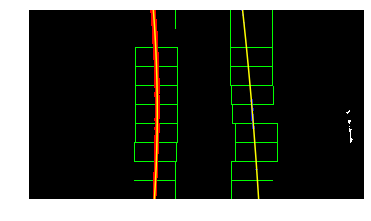

In [18]:
# 可视化测试用例
img = cv2.imread('./test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_bin, Minv = pipeline(img)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(img_bin)

h = img.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((img_bin, img_bin, img_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, img_bin.shape[0]-1, img_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = img_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.axis('off')
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [19]:
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

In [21]:
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    """
    计算曲率半径和偏移中心距离
    """
    
    ym_per_pix = 3.048/100
    xm_per_pix = 3.7/378
    left_curverad, right_curverad, center_dist = (0, 0, 0)
   
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
     
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [22]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 479.9682745093776 m, 1452.849139270027 m
Distance from lane center for example: -0.3667664362000666 m


In [23]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    """
    绘制车道线和可行区域
    """
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # 变换回原图
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

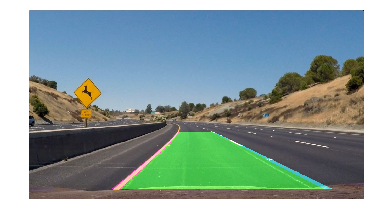

In [24]:
img_out = draw_lane(img, img_bin, left_fit, right_fit, Minv)
plt.axis('off')
plt.imshow(img_out)
plt.show()

In [25]:
def draw_data(original_img, curv_rad, center_dist):
    """
    添加信息
    """
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    return new_img

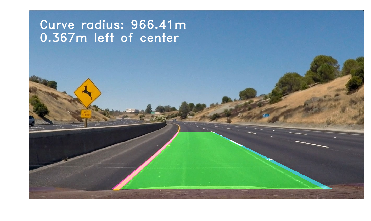

In [26]:
img_out = draw_data(img_out, (rad_l+rad_r)/2, d_center)
plt.axis('off')
plt.imshow(img_out)
plt.show()

In [51]:
def full_pipeline(img_raw):
    img = img_raw
    img_bin, Minv = pipeline(img)
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(img_bin)
    left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(img_bin, left_fit, right_fit)
    rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)
    img_out = draw_lane(img, img_bin, left_fit, right_fit, Minv)
    img_out = draw_data(img_out, (rad_l+rad_r)/2, d_center)
    return img_out

In [53]:
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(full_pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:19<00:00, 15.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 32s, sys: 10.8 s, total: 2min 42s
Wall time: 1min 19s


In [54]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))